In [1]:
import copy
from itertools import product
from classification_refined import classify
from processing import *
from readfiles import *
from decision import filter_summary
from subgraphclass import make_solver_summary
from sklearn.model_selection import train_test_split
from classification_refined import *
import networkx as nx
from readfiles import *
from metrics import *
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from readfiles import corresp_label_file


In [2]:
num = 84  # number of nodes in the graph
tri = int(num * (num + 1) * 0.5)  # we want only the upper diagonal due to symettry of connections
edge_names = ['mean_FA', 'mean_strl', 'num_streamlines']
mat = np.triu_indices(84)
mews = '/home/skapoor/Thesis/gmwcs-solver'
metrics = ['balanced_accuracy', 'accuracy', 'f1_weighted', 'roc_auc_ovr_weighted']
edges = ['fscores', 't_test']
labels = ['Gender']
mapping = {'Gender': 'Gender'}

In [3]:
target, feature, edge, solver_node_wts = 'Gender', 'num_streamlines', 'fscores','const'
val, thresh, max_num_nodes, per = -0.01, 0, 10, 1.15
choice, classifier, refit_metric, feature_selection = 'random', 'SVC', 'balanced_accuracy', 'baseline'
baseline_cases, self_loops = set(), False

In [4]:
# note: right now the matrix whole is not scaled, for computing the fscores and correlation coeff it has to be so.
y_train, y_test = computed_subjects(), test_subjects()
y_train_l, y_test_l = y_train[target].map({'M': 0, 'F': 1}), y_test[target].map({'M': 0, 'F':1})
X_train = generate_combined_matrix(tri, list(y_train.index))  # need to check indices till here then convert to numpy array
X_test = generate_test_data(tri, y_test.index)
X_train_l, X_test_l = edge_filtering(feature, X_train, X_test)

X, y = X_train_l.append(X_test_l), y_train_l.append(y_test_l)

In [5]:
assert list(X.index) == list(y.index)

In [6]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(X, y)

print(skf)
results_solver = []
avg_thresh, self_loops = False, False
feature_selection = 'solver'
refit_metric = 'balanced_accuracy'
nodes = []
node_names = []
i =0 
for train_index, test_index in skf.split(X, y):
    i+=1
    #print("TRAIN:",len(train_index), train_index, "TEST:", len(test_index),test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    case = (classifier, target, choice, edge, feature_selection, feature, per, refit_metric, self_loops)
    # the baseline needs self loops command but the solver does not!
        # drop the diagonal indices from the columns
    strls_num = X_train
    if feature_selection == 'solver':
        print(classifier, feature_selection, choice, refit_metric, target, feature, edge,
              solver_node_wts)
        strls_num_l = strls_num.loc[X_train.index, :]
        if avg_thresh == True:
            strls_num_l = strls_num.mean(axis=0, skipna=True)
        else:
            # to check if there is atleast one or more streamlines for that particular feature for all subjects
            strls_num_l = strls_num_l.all()
        if i<4:
            keep_files = False
        else:
            keep_files = True
        X_train, X_test, output_graph = solver_pub(X_train, X_test, y_train, strls_num_l,feature, thresh,
                                                        val,
                                                        max_num_nodes, avg_thresh,
                                                        node_wts=solver_node_wts, target=target, 
                                                   edge=edge,keep_files=keep_files )
        
        nodes.append(list(output_graph.nodes))
        node_names.append(output_graph.node_labels)
        edge_wts = output_graph.edge_weights
        if len(edge_wts) != 0:
            train_res, test_res = cross_validation(classifier, X_train, y_train, X_test, y_test,
                                                   metrics, refit_metric)
            # to make the program faster only do this when the solver is actually producing some results
            results_solver.append(
                [classifier, target, choice, edge, feature_selection, feature, len(edge_wts) * 100 / (tri-84),
                 refit_metric, max_num_nodes,
                 len(edge_wts), sum([edge > 0 for edge in edge_wts]) * 100 / len(edge_wts)])
            results_solver[-1].append(thresh)
            for metric in metrics:
                results_solver[-1].extend([round(100*train_res[metric],3)])
            for metric in metrics:
                results_solver[-1].extend([round(100*test_res[metric],3)])
        

StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
SVC solver random balanced_accuracy Gender num_streamlines fscores const
Best estimator {'C': 10.454350089011617, 'class_weight': None, 'gamma': 0.0016968091171377354, 'kernel': 'rbf'}
SVC solver random balanced_accuracy Gender num_streamlines fscores const
Best estimator {'C': 277.71598372456145, 'class_weight': None, 'gamma': 0.0009153891549017183, 'kernel': 'sigmoid'}
SVC solver random balanced_accuracy Gender num_streamlines fscores const
Best estimator {'C': 20.011299206049834, 'class_weight': None, 'gamma': 0.0026778967039994685, 'kernel': 'sigmoid'}
SVC solver random balanced_accuracy Gender num_streamlines fscores const
Best estimator {'C': 277.71598372456145, 'class_weight': None, 'gamma': 0.0009153891549017183, 'kernel': 'sigmoid'}
SVC solver random balanced_accuracy Gender num_streamlines fscores const
Best estimator {'C': 0.5460087469400233, 'class_weight': 'balanced', 'gamma': 0.000590135757312644, 'kernel': 'lin

In [7]:
a = np.sort(np.concatenate(nodes).flat)

d1 = {k-1:v for k,v in corresp_label_file('fs_default.txt').items() if k-1 in np.unique(a)}

d2 = {}
for k,v in zip(range(len(np.unique(a))), np.unique(a)):
    d2[v] = k

for i in range(len(a)):
    a[i] = d2[a[i]]

In [28]:
#plt.hist(a, bins=len(np.unique(a)))

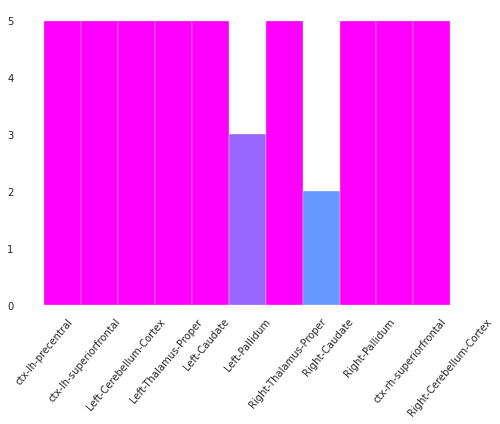

In [14]:
cm = plt.cm.get_cmap('cool')


fig, ax = plt.subplots()
counts, bins, patches = ax.hist(a, bins=len(np.unique(a)))
for c, p in zip(counts, patches):
    plt.setp(p, 'facecolor', cm(c/5))
# Set the ticks to be at the edges of the bins.
plt.xticks(range(len(np.unique(a))),list(d1.values()), rotation=50)
plt.show()

In [15]:
## Parameter settings decided on the basis of thesis

In [16]:
def find_indices(lin):
    """
    Takes a list of indices and finds the corresponding row and column numbers.
    The row and column numbers represent the node number in the LUT.
    
    Parameters:
    lin (int): List of integer indices 
    
    Returns:
    d1 (dict): key-value pair of edges and corresponding nodes
    """
    d1 = {}
    mat = np.triu_indices(84)
    nondiag = list(set(range(3570)).difference(set(diag_flattened_indices(84))))
    for idx in lin: 
        for i in range(len(mat[0])):
            if i == idx:
                d1[idx] = (mat[0][i], mat[1][i])
    return d1

In [17]:
ip = BrainGraph('fscores', 'num_streamlines', 'const', 'Gender', 10, -0.01, 0)
feature_indices = ip.read_from_file(mews, False)
#ip.visualize_graph(mews, False, plotting_options=graph_options('red',10, 'yellow', 2, 1.5),
#                   figs=(10,6))
G = ip

In [18]:
feature_indices

[1621,
 1629,
 1630,
 1631,
 1633,
 1670,
 1678,
 1867,
 1868,
 1869,
 1871,
 1875,
 1878,
 1908,
 1916,
 2296,
 2297,
 2303,
 2306,
 2336,
 2344,
 2346,
 2348,
 2352,
 2355,
 2385,
 2393,
 2396,
 2400,
 2433,
 2441,
 2526,
 2670,
 2700,
 2708,
 2820,
 2828,
 3533]

In [19]:
num_strls = X

In [20]:
d1 = find_indices(feature_indices)
ew = G.edge_weights

In [21]:
G.edges

EdgeView([(34, 83), (34, 45), (34, 42), (34, 26), (34, 35), (34, 36), (34, 75), (34, 22), (35, 75), (35, 42), (35, 22), (35, 83), (35, 36), (35, 38), (35, 26), (35, 45), (36, 22), (36, 38), (36, 26), (36, 42), (36, 75), (36, 83), (38, 75), (38, 22), (38, 26), (42, 45), (42, 26), (42, 83), (42, 75), (75, 22), (75, 26), (75, 45), (75, 83), (45, 26), (45, 83), (83, 22), (83, 26), (22, 26)])

In [22]:
num_strls.columns = num_strls.columns - 2*3570

In [23]:
num_strls

,0,1,2,3,4,5,6,7,8,9,...,3560,3561,3562,3563,3564,3565,3566,3567,3568,3569
128127,929.0,0.0,25.0,2.0,0.0,2.0,946.0,30.0,1.0,17.0,...,82.0,1.0,656.0,0.0,485.0,205.0,0.0,3186.0,12.0,47285.0
129028,1165.0,0.0,20.0,6.0,0.0,9.0,862.0,31.0,11.0,17.0,...,242.0,0.0,575.0,0.0,294.0,151.0,0.0,5213.0,18.0,44125.0
129331,1578.0,0.0,8.0,1.0,0.0,15.0,1048.0,220.0,2.0,10.0,...,351.0,0.0,633.0,0.0,499.0,449.0,0.0,4787.0,26.0,62786.0
129937,1002.0,0.0,5.0,1.0,0.0,5.0,488.0,30.0,5.0,20.0,...,558.0,0.0,673.0,0.0,313.0,279.0,0.0,4440.0,4.0,63220.0
130013,1587.0,0.0,33.0,1.0,0.0,2.0,615.0,60.0,2.0,7.0,...,337.0,0.0,510.0,0.0,339.0,75.0,0.0,4026.0,6.0,42755.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202113,955.0,0.0,68.0,8.0,1.0,30.0,442.0,180.0,21.0,18.0,...,993.0,0.0,463.0,1.0,581.0,434.0,0.0,5083.0,13.0,54602.0
202719,971.0,0.0,9.0,3.0,0.0,3.0,278.0,101.0,9.0,13.0,...,338.0,0.0,942.0,0.0,338.0,281.0,0.0,4473.0,2.0,55669.0
204016,1216.0,0.0,28.0,0.0,1.0,13.0,605.0,129.0,3.0,30.0,...,74.0,0.0,306.0,0.0,930.0,244.0,0.0,4661.0,8.0,46356.0
205725,987.0,0.0,14.0,3.0,0.0,2.0,508.0,83.0,1.0,11.0,...,150.0,0.0,558.0,7.0,235.0,189.0,0.0,3820.0,4.0,78691.0


In [24]:
tups = []
nums = []
d1 = find_indices(feature_indices)
for edge, index in zip(G.edges, feature_indices):
    tups.append((edge[0], edge[1], num_strls.loc[:, index].mean()))
    nums.append(num_strls.loc[:, index].mean())

In [25]:
G.add_weighted_edges_from(tups)

In [26]:
import matplotlib.cm as cm

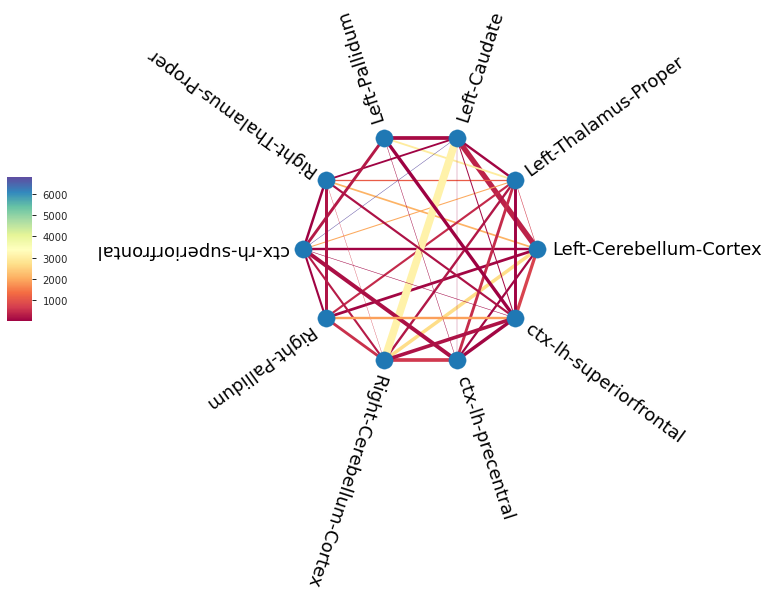

In [27]:
minima = min(nums)
maxima = max(nums)
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima)
mapper = cm.ScalarMappable(norm=norm, cmap=plt.get_cmap('Spectral'))
color = []
for v in nums:
    color.append(mapper.to_rgba(v))
    
    
n = len(G.nodes)
node_list = list(G.nodes)
angle = []
angle_dict = {}
for i, node in zip(range(n),node_list):
    theta = 2.0*np.pi*i/n
    angle.append((np.cos(theta),np.sin(theta)))
    angle_dict[node] = theta
pos = {}
for node_i, node in enumerate(node_list):
    pos[node] = angle[node_i]

labels = {}
for node, i in zip(G.nodes, range(len(G.nodes))):
    labels[node] = G.node_labels[i]
# figsize is intentionally set small to condense the graph
fig, ax = plt.subplots(figsize=(11.5,10))
margin=0.33
fig.subplots_adjust(margin, margin, 1.-margin, 1.-margin)
ax.axis('equal')

nx.draw(G,pos=pos,with_labels=False, ax=ax, edge_color=color, edge_cmap=mapper.cmap, vmin=minima,
                        vmax=maxima, width=[i*20 for i in ew], rotate=60)
description = nx.draw_networkx_labels(G,pos,labels=labels, font_size=18)

r = fig.canvas.get_renderer()
trans = plt.gca().transData.inverted()
for node, t in description.items():
    bb = t.get_window_extent(renderer=r)
    bbdata = bb.transformed(trans)
    radius = 1.2+bbdata.width/2.
    position = (radius*np.cos(angle_dict[node]),radius* np.sin(angle_dict[node]))
    t.set_position(position)
    t.set_rotation(angle_dict[node]*360.0/(2.0*np.pi))
    t.set_clip_on(False)
cbaxes = fig.add_axes([0.001, 0.4, 0.03, 0.2])  # This is the position for the colorbar
cb = plt.colorbar(mapper, cax = cbaxes)
plt.savefig('outputs/figures/solver_10nodes_strls.png')
plt.show()